#### Загрузка набора данных

In [12]:
import pandas as pd

from sklearn import set_config

set_config(transform_output="pandas")

random_state=9

df = pd.read_csv("data/Medical_insurance.csv", index_col=False)

df["smoker"] = df["smoker"].apply(lambda x: 1 if x == "yes" else 0)

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи классификации

Целевой признак -- Survived

In [13]:
from utils import split_stratified_into_train_val_test
X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df, stratify_colname="smoker", target_colname="smoker",frac_train=0.80, frac_val=0, frac_test=0.20, random_state=random_state
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

age     sex     bmi  children  smoker     region      charges
671    29  female  31.160         0       0  northeast   3943.59540
808    18    male  30.140         0       0  southeast   1131.50660
795    27    male  28.500         0       1  northwest  18310.74200
576    22    male  26.840         0       0  southeast   1664.99960
1232   54  female  24.605         3       0  northwest  12479.70895
...   ...     ...     ...       ...     ...        ...          ...
105    20    male  28.025         1       1  northwest  17560.37975
461    42    male  30.000         0       1  southwest  22144.03200
2650   49  female  33.345         2       0  northeast  10370.91255
1674   59  female  36.765         1       1  northeast  47896.79135
2689   43    male  27.800         0       1  southwest  37829.72420

[2217 rows x 7 columns]

'y_train'

smoker
671        0
808        0
795        1
576        0
1232       0
...      ...
105        1
461        1
2650       0
1674       1
2689       1

[2217 rows x 1 columns]

'X_test'

age     sex     bmi  children  smoker     region      charges
124    47  female  33.915         3       0  northwest  10115.00885
778    35    male  34.320         3       0  southeast   5934.37980
372    42  female  33.155         1       0  northeast   7639.41745
1969   32  female  23.650         1       0  southeast  17626.23951
2522   44  female  25.000         1       0  southwest   7623.51800
...   ...     ...     ...       ...     ...        ...          ...
908    63    male  39.800         3       0  southwest  15170.06900
1203   51    male  32.300         1       0  northeast   9964.06000
45     55    male  37.300         0       0  southwest  20630.28351
2669   18    male  30.030         1       0  southeast   1720.35370
1230   52    male  34.485         3       1  northwest  60021.39897

[555 rows x 7 columns]

'y_test'

smoker
124        0
778        0
372        0
1969       0
2522       0
...      ...
908        0
1203       0
45         0
2669       0
1230       1

[555 rows x 1 columns]

#### Формирование конвейера для классификации данных

preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing -- трансформер для предобработки признаков

features_engineering -- трансформер для конструирования признаков

drop_columns -- трансформер для удаления колонок

features_postprocessing -- трансформер для унитарного кодирования новых признаков

pipeline_end -- основной конвейер предобработки данных и конструирования признаков

Конвейер выполняется последовательно.

Трансформер выполняет параллельно для указанного набора колонок.

Документация: 

https://scikit-learn.org/1.5/api/sklearn.pipeline.html

https://scikit-learn.org/1.5/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

columns_to_drop = ["smoker"]
num_columns = [
    column
    for column in df.columns
    if df[column].dtype != "object"
]
cat_columns = [
    column
    for column in df.columns
    if df[column].dtype == "object"
]

num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_num", preprocessing_num, num_columns),
        ("prepocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

#### Демонстрация работы конвейера для предобработки данных при классификации

In [24]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

age       bmi  children   charges  sex_male  region_northwest  \
671  -0.730722  0.085028 -0.907368 -0.769241       0.0               0.0   
808  -1.513302 -0.081153 -0.907368 -0.999824       1.0               0.0   
795  -0.873009 -0.348348 -0.907368  0.408827       1.0               1.0   
576  -1.228727 -0.618800 -0.907368 -0.956079       1.0               0.0   
1232  1.047868 -0.982934  1.555858 -0.069302       0.0               1.0   
...        ...       ...       ...       ...       ...               ...   
105  -1.371015 -0.425736 -0.086293  0.347299       1.0               1.0   
461   0.194145 -0.103963 -0.907368  0.723147       1.0               0.0   
2650  0.692150  0.441016  0.734783 -0.242218       0.0               0.0   
1674  1.403586  0.998214 -0.086293  2.834804       0.0               0.0   
2689  0.265288 -0.462394 -0.907368  2.009332       1.0               0.0   

      region_southeast  region_southwest  
671                0.0               0.0  
808                1.0               0.0  
795                0.0               0.0  
576                1.0               0.0  
1232               0.0               0.0  
...                ...               ...  
105                0.0               0.0  
461                0.0               1.0  
2650               0.0               0.0  
1674               0.0               0.0  
2689               0.0               1.0  

[2217 rows x 8 columns]

#### Формирование набора моделей для классификации

logistic -- логистическая регрессия

ridge -- гребневая регрессия

decision_tree -- дерево решений

knn -- k-ближайших соседей

naive_bayes -- наивный Байесовский классификатор

gradient_boosting -- метод градиентного бустинга (набор деревьев решений)

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

Документация: https://scikit-learn.org/1.5/supervised_learning.html

In [25]:
from sklearn import ensemble, linear_model, naive_bayes, neighbors, neural_network, tree

class_models = {
    "logistic": {"model": linear_model.LogisticRegression()},
    # "ridge": {"model": linear_model.RidgeClassifierCV(cv=5, class_weight="balanced")},
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=random_state)
    },
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=random_state
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=random_state,
        )
    },
}

#### Обучение моделей на обучающем наборе данных и оценка на тестовом

In [26]:
import numpy as np # type: ignore
from sklearn import metrics

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic
Model: ridge
Model: decision_tree
Model: knn
Model: naive_bayes
Model: gradient_boosting
Model: random_forest
Model: mlp


#### Сводная таблица оценок качества для использованных моделей классификации

Документация: https://scikit-learn.org/1.5/modules/model_evaluation.html

Матрица неточностей

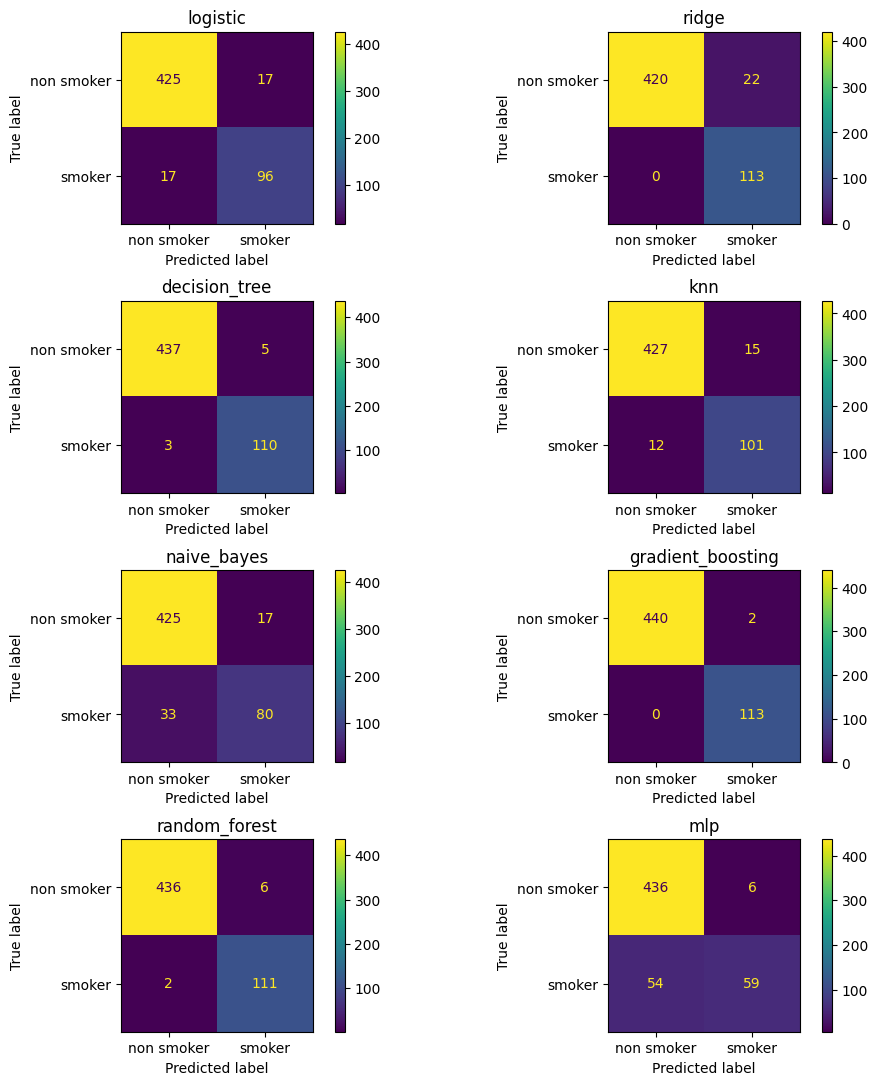

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)
for index, key in enumerate(class_models.keys()):
    c_matrix = class_models[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["non smoker", "smoker"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

Точность, полнота, верность (аккуратность), F-мера

In [30]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [31]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

In [32]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'gradient_boosting'

#### Вывод данных с ошибкой предсказания для оценки

In [34]:
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

y_pred = class_models[best_model]["preds"]

error_index = y_test[y_test["smoker"] != y_pred].index.tolist()
display(f"Error items count: {len(error_index)}")

error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df.sort_index()

'Error items count: 2'

age  Predicted     sex    bmi  children  smoker     region      charges
583    32          1  female  23.65         1       0  southeast  17626.23951
1969   32          1  female  23.65         1       0  southeast  17626.23951

#### Пример использования обученной модели (конвейера) для предсказания

In [46]:
model = class_models[best_model]["pipeline"]

example_id = 1969
print(X_test.loc[example_id, :])
test = pd.DataFrame(X_test.loc[example_id, :]).T
test_preprocessed = pd.DataFrame(preprocessed_df.loc[example_id, :]).T
display(test)
display(test_preprocessed)
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]
real = int(y_test.loc[example_id].values[0])
display(f"predicted: {result} (proba: {result_proba})")
display(f"real: {real}")

age                  32
sex              female
bmi               23.65
children              1
smoker                0
region        southeast
charges     17626.23951
Name: 1969, dtype: object


age     sex    bmi children smoker     region      charges
1969  32  female  23.65        1      0  southeast  17626.23951

age       bmi  children  charges  sex_male  region_northwest  \
1969 -0.517291 -1.138526 -0.086293   0.3527       0.0               0.0   

      region_southeast  region_southwest  
1969               1.0               0.0

'predicted: 1 (proba: [0.01087081 0.98912919])'

'real: 0'

#### Подбор гиперпараметров методом поиска по сетке

https://www.kaggle.com/code/sociopath00/random-forest-using-gridsearchcv

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [47]:
from sklearn.model_selection import GridSearchCV

optimized_model_type = "random_forest"

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 20, 30, 40, 50, 100, 150, 200, 250, 500],
    "model__max_features": ["sqrt", "log2", 2],
    "model__max_depth": [2, 3, 4, 5, 6, 7, 8, 9 ,10],
    "model__criterion": ["gini", "entropy", "log_loss"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_

c:\Users\frenk\OneDrive\Рабочий стол\MII_Salin_Oleg_PIbd-33\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model__criterion': 'entropy',
 'model__max_depth': 10,
 'model__max_features': 'log2',
 'model__n_estimators': 250}

Обучение модели с новыми гиперпараметрами

In [48]:
optimized_model = ensemble.RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=7,
    max_features="sqrt",
    n_estimators=30,
)

result = {}

result["pipeline"] = Pipeline([("pipeline", pipeline_end), ("model", optimized_model)]).fit(X_train, y_train.values.ravel())
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

Формирование данных для оценки старой и новой версии модели

In [49]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

Оценка параметров старой и новой модели

In [50]:
optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

In [51]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

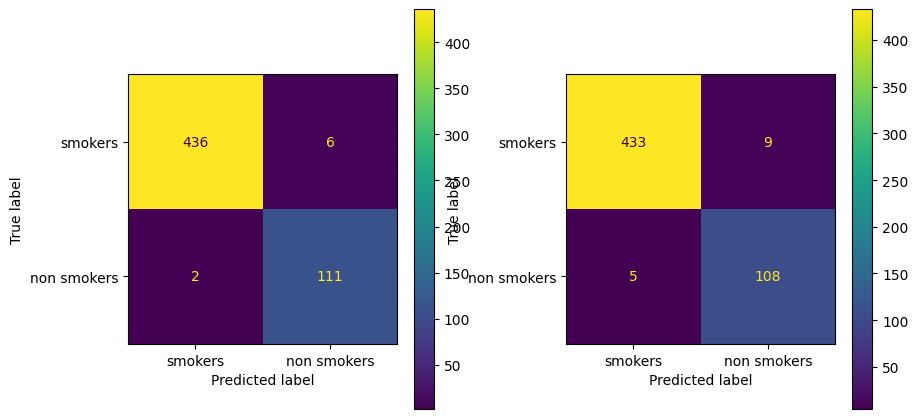

In [52]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False
)

for index in range(0, len(optimized_metrics)):
    c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["smokers", "non smokers"]
    ).plot(ax=ax.flat[index])

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()